# <span style="color:#C147E9">Software Engineer salary Prediction</span>


### <span style="color:#FFDCA9">Predicting software developer salary from Stack Overflow survey data using years of experience and location</span> 


#### <span style="color:#46C2CB">Importing libraries</span>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import pickle 

c:\Users\kanna\anaconda3\envs\ML\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### <span style="color:#46C2CB">Importing data</span>

In [2]:
df = pd.read_csv("./Data/survey_results_public.csv")

#### <span style="color:#46C2CB">Exploring data</span>


In [3]:
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-null  object 
 13  D

In [5]:
df.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,64461.000000,45446.000000,3.482600e+04,3.475600e+04,41151.000000
mean,32554.079738,30.834111,3.190464e+242,1.037561e+05,40.782174
std,18967.442360,9.585392,inf,2.268853e+05,17.816383
min,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,16116.000000,24.000000,2.000000e+04,2.464800e+04,40.000000
50%,32231.000000,29.000000,6.300000e+04,5.404900e+04,40.000000
75%,49142.000000,35.000000,1.250000e+05,9.500000e+04,44.000000
max,65639.000000,279.000000,1.111111e+247,2.000000e+06,475.000000


#### <span style="color:#46C2CB">Exploring Data</span>

- <span style="color:#CFFF8D">We are only going to consider the following columns; country, EdLevel, YearsCodePro, ConvertedComp (salary) as we are predicting salary based on years of experience and location.</span>

In [6]:
df = df[["Country", "EdLevel", "YearsCodePro", "Employment", "ConvertedComp"]]
df = df.rename({"ConvertedComp": "Salary"}, axis=1)
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary
0,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27,"Independent contractor, freelancer, or self-em...",NaN
1,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,Employed full-time,NaN
2,Russian Federation,NaN,NaN,NaN,NaN
3,Albania,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,NaN,NaN
4,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,Employed full-time,NaN


- <span style="color:#CFFF8D">We are selecting the rows where the salary is not null.</span>

In [7]:
df = df[df["Salary"].notnull()]
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary
7,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13,Employed full-time,116000.0
9,United Kingdom,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,Employed full-time,32315.0
10,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,Employed full-time,40070.0
11,Spain,Some college/university study without earning ...,7,Employed full-time,14268.0
12,Netherlands,"Secondary school (e.g. American high school, G...",20,Employed full-time,38916.0


- <span style="color:#CFFF8D">Dropping the all the columns with at least one null value.</span>

In [8]:
df = df.dropna()
df.isnull().sum()

Country         0
EdLevel         0
YearsCodePro    0
Employment      0
Salary          0
dtype: int64

- <span style="color:#CFFF8D">Changing the name of a column</span>


In [9]:
df = df[df["Employment"] == "Employed full-time"]
df = df.drop("Employment", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30019 entries, 7 to 64154
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       30019 non-null  object 
 1   EdLevel       30019 non-null  object 
 2   YearsCodePro  30019 non-null  object 
 3   Salary        30019 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [10]:
df['Country'].value_counts()

United States     7569
India             2425
United Kingdom    2287
Germany           1903
Canada            1178
                  ... 
Benin                1
Fiji                 1
San Marino           1
Guinea               1
Andorra              1
Name: Country, Length: 154, dtype: int64

### <span style="color:#CFFF8D">Feature Engineering</span>


In [11]:
# we want the countries with more than 300 respondents

def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

country_map = shorten_categories(df.Country.value_counts(), 300)
df['Country'] = df['Country'].map(country_map)
df.Country.value_counts()

Other                 7922
United States         7569
India                 2425
United Kingdom        2287
Germany               1903
Canada                1178
Brazil                 991
France                 972
Spain                  670
Australia              659
Netherlands            654
Poland                 566
Italy                  560
Russian Federation     522
Sweden                 514
Turkey                 327
Israel                 300
Name: Country, dtype: int64

### <span style="color:#CFFF8D">Visualizing the Data</span>


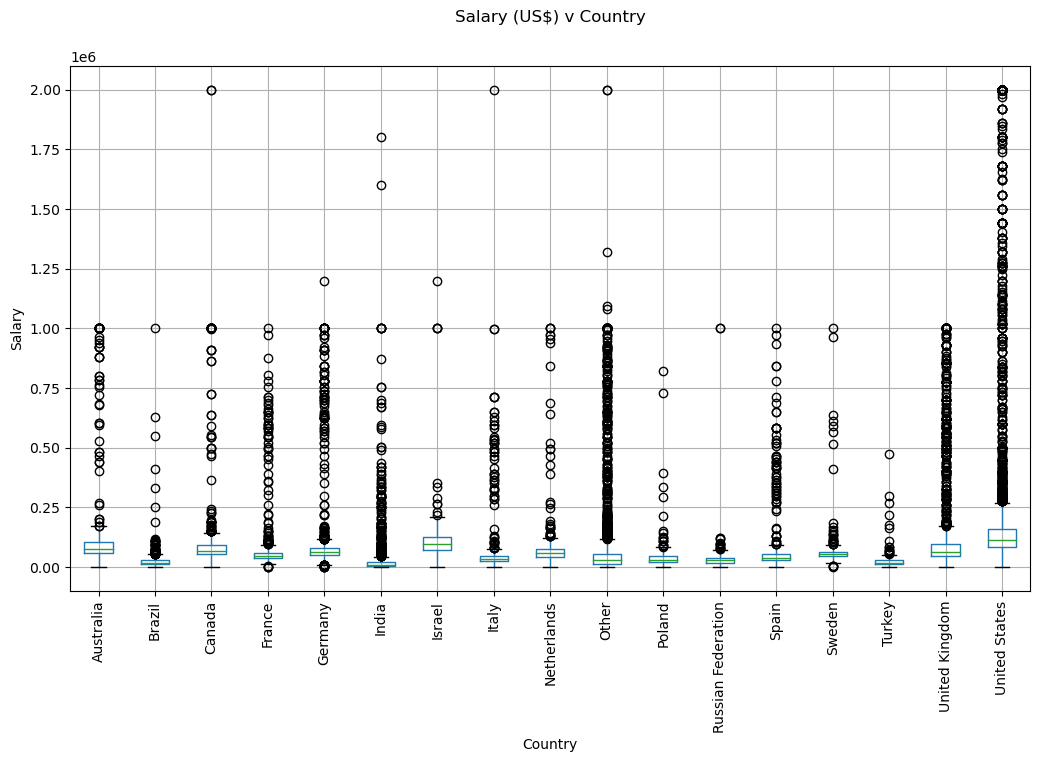

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()


### <span style="color:#CFFF8D">Outlier Removal</span>


In [13]:
# we are only considering the salary 300000 and below 

df = df[df["Salary"] <= 250000]
df = df[df["Salary"] >= 6000]
df = df[df['Country'] != 'Other']

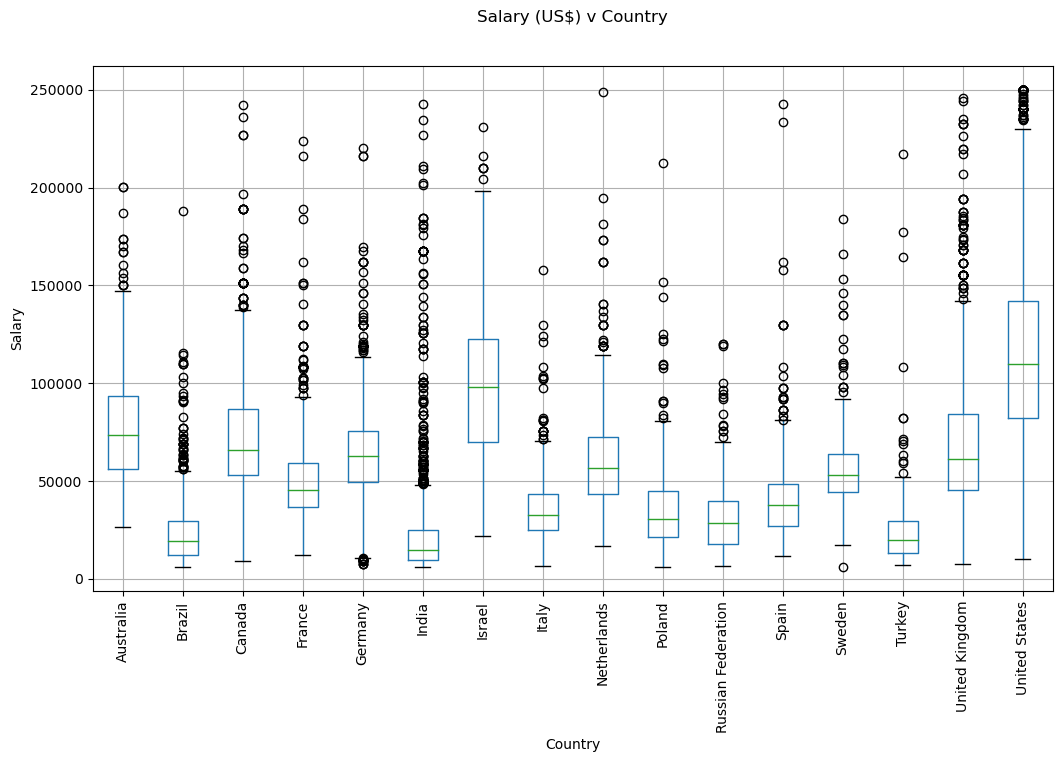

In [14]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

- Cleaning experience column

In [15]:
df["YearsCodePro"].unique()

array(['13', '4', '2', '7', '20', '1', '3', '10', '12', '29', '6', '28',
       '8', '23', '15', '25', '9', '11', 'Less than 1 year', '5', '21',
       '16', '18', '14', '32', '19', '22', '38', '30', '26', '27', '17',
       '24', '34', '35', '33', '36', '40', '39', 'More than 50 years',
       '31', '37', '41', '45', '42', '44', '43', '50', '49'], dtype=object)

### <span style="color:#CFFF8D">Dimensionality Reduction</span>


In [16]:
def clean_experience(x):
    if x ==  'More than 50 years':
        return 50
    if x == 'Less than 1 year':
        return 0.5
    return float(x)

df['YearsCodePro'] = df['YearsCodePro'].apply(clean_experience)

- Education

In [17]:
df["EdLevel"].unique()

array(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Some college/university study without earning a degree',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Professional degree (JD, MD, etc.)',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'I never completed any formal education',
       'Primary/elementary school'], dtype=object)

In [18]:
def clean_education(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than a Bachelors'

df['EdLevel'] = df['EdLevel'].apply(clean_education)

In [19]:
df["EdLevel"].unique()

array(['Bachelor’s degree', 'Master’s degree', 'Less than a Bachelors',
       'Post grad'], dtype=object)

In [20]:
le_education = LabelEncoder()
df['EdLevel'] = le_education.fit_transform(df['EdLevel'])
df["EdLevel"].unique()

array([0, 2, 1, 3])

In [21]:
le_country = LabelEncoder()
df['Country'] = le_country.fit_transform(df['Country'])
df["Country"].unique()

array([15, 14, 11,  8,  4,  2,  7,  1,  3,  5,  6, 12, 13,  9,  0, 10])

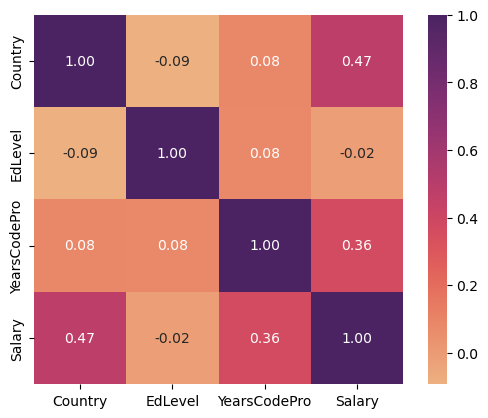

In [22]:
corrmat = df.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=df.columns, 
                 xticklabels=df.columns, 
                 cmap="flare")
plt.show()

#### <span style="color:#CFFF8D">This heatmap shows the correlation between the columns</span>

- Salary is highly correlated with years of experience (Positive correlation)
- Salary is correlated with country (positive correlation)
- salary is not correlated with education level (negative correlation)

**The negative correlation between salary and education level is not what something we would expect. This is may be due multiple reasons;**

- The survey data is not representative of the population
- People with higher education may less likely to respond to the survey
- People with higher education may be more likely go into management, Teaching, or other non-coding roles

In [23]:
X = df.drop("Salary", axis=1)
y = df["Salary"]

### <span style="color:#CFFF8D">Trying Different Models</span>


#### 1.  Linear Regression

- <span style="color:#CFFF8D">Simple linear regression is a type of regression analysis where the number of independent variables is one and there is a linear relationship between the independent(x) and dependent(y) variable. </span>

- <span style="color:#CFFF8D">Absolute error refers to the magnitude of difference between the prediction of an observation and the true value of that observation. </span>

- <span style="color:#CFFF8D">  MAE takes the average of absolute errors for a group of predictions and observations as a measurement of the magnitude of errors for the entire group. The lower the MAE, the better the model is at predicting the response. </span>

- <span style="color:#CFFF8D">The MSE is the average of the squared differences between the prediction and the actual observation. The lower the MSE, the better the model is at predicting the response. Values closer to zero are better. </span>

- <span style="color:#CFFF8D">The explained variance score is a measure of how well future samples are likely to be predicted by the model. The best possible score is 1.0 </span>

- <span style="color:#CFFF8D">The R2 score is the percentage of the response variable variation that is explained by a linear model. The best possible score is 1.0 </span>


In [24]:
linear_reg = LinearRegression()
linear_reg.fit(X, y.values)

y_pred = linear_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$39,794.42


In [25]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y, y_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y, y_pred), 2))

Mean absolute error = 31047.41
Mean squared error = 1583595899.48
Median absolute error = 26638.92
Explain variance score = 0.33
R2 score = 0.33


**RMSE using Linear Regression is : 39, 794**

### Decision Tree Regression

### Decision Tree Regression

- <span style="color:#CFFF8D">Decision tree is a supervised learning algorithm that can be used for both classification and regression tasks. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. This model is a tree-like structure where each internal node denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node holds a class label. </span>

In [26]:
dec_tree_reg = DecisionTreeRegressor(random_state=0)
dec_tree_reg.fit(X, y.values)

y_pred = dec_tree_reg.predict(X)
error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$28,849.94


In [27]:
print("Mean absolute error =", round(sm.mean_absolute_error(y, y_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y, y_pred), 2))

Mean absolute error = 19377.68
Mean squared error = 832318915.25
Median absolute error = 12425.04
Explain variance score = 0.65
R2 score = 0.65


**RMSE using Decision Tree Regression is : 28849**

### Random Forest Regression

- <span style="color:#CFFF8D">Random forest is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. It is a type of ensemble learning algorithm, which combines multiple decision trees to provide solutions. It is a bagging technique where the final output is calculated by taking the average of all the predictions of the decision trees. </span>

- **Ensemble methods** use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

- **Bagging** is a general-purpose procedure for reducing the variance of a statistical learning method. Bagging can be applied to any method that has high variance, including decision trees, neural networks, and linear regression.

In [28]:
random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X, y.values)

y_pred = random_forest_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$28,929.82


In [29]:
print("Mean absolute error =", round(sm.mean_absolute_error(y, y_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y, y_pred), 2))

Mean absolute error = 19582.04
Mean squared error = 836934743.82
Median absolute error = 12644.68
Explain variance score = 0.65
R2 score = 0.65


### Support Vector Regression

- <span style="color:#CFFF8D">Support Vector Regression (SVR) is a type of supervised machine learning algorithm that is used for regression analysis. It is mostly used for classification problems. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. </span>

In [30]:
from sklearn.svm import SVR


svr_reg = SVR(kernel='rbf')
svr_reg.fit(X, y.values)

y_pred = svr_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$48,717.44


In [33]:
print("Mean absolute error =", round(sm.mean_absolute_error(y, y_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y, y_pred), 2))

Mean absolute error = 20695.29
Mean squared error = 913172007.56
Median absolute error = 13701.75
Explain variance score = 0.61
R2 score = 0.61


**RMSE using Support Vector Regression is :  48717.44**

### Gradient Boosting Regression

- <span style="color:#CFFF8D">Gradient Boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. </span>

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_reg = GradientBoostingRegressor(random_state=0)
gbr_reg.fit(X, y.values)

y_pred = gbr_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$30,218.74


In [34]:
print("Mean absolute error =", round(sm.mean_absolute_error(y, y_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y, y_pred), 2))

Mean absolute error = 20695.29
Mean squared error = 913172007.56
Median absolute error = 13701.75
Explain variance score = 0.61
R2 score = 0.61


**RMSE using Gradient boosting Regressor is :  30, 218.74**

### Ada Boost Regression

- <span style="color:#CFFF8D">AdaBoost is a machine learning meta-algorithm formulated by Yoav Freund and Robert Schapire. It is a boosting algorithm that can be used to convert weak learners to strong ones. It is a type of ensemble learning algorithm that combines multiple weak learners to form a strong learner. </span>

In [35]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(random_state=0)
ada_reg.fit(X, y.values)


y_pred = ada_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$35,668.83


In [36]:
print("Mean absolute error =", round(sm.mean_absolute_error(y, y_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y, y_pred), 2))

Mean absolute error = 28545.13
Mean squared error = 1272265582.62
Median absolute error = 25932.9
Explain variance score = 0.52
R2 score = 0.46


**RMSE using AdaBoost Regressor is :  35, 668.83**

### Bagging Regression

- <span style="color:#CFFF8D">Bagging is a general-purpose procedure for reducing the variance of a statistical learning method. Bagging can be applied to any method that has high variance, including decision trees, neural networks, and linear regression. </span>

In [41]:
from sklearn.ensemble import BaggingRegressor

bag_reg = BaggingRegressor(random_state=0)
bag_reg.fit(X, y.values)

y_pred = bag_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))



$29,021.73


In [42]:
print("Mean absolute error =", round(sm.mean_absolute_error(y, y_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y, y_pred), 2))

Mean absolute error = 19642.78
Mean squared error = 842260824.74
Median absolute error = 12588.61
Explain variance score = 0.64
R2 score = 0.64


**RMSE using Bagging Regressor is :  30, 29021**

### Extra Trees Regression

- <span style="color:#CFFF8D">Extra Trees is an ensemble learning algorithm that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. </span>

In [43]:
from sklearn.ensemble import ExtraTreesRegressor

extra_reg = ExtraTreesRegressor(random_state=0)
extra_reg.fit(X, y.values)

y_pred = extra_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$28,849.94


In [44]:
print("Mean absolute error =", round(sm.mean_absolute_error(y, y_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y, y_pred), 2))

Mean absolute error = 19377.68
Mean squared error = 832318915.25
Median absolute error = 12425.04
Explain variance score = 0.65
R2 score = 0.65


**RMSE using Extra Trees Regressor is :  28849**

In [45]:
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(estimators=[('lr', linear_reg), ('dt', dec_tree_reg), ('rf', random_forest_reg), ('svr', svr_reg), ('gbr', gbr_reg), ('ada', ada_reg), ('bag', bag_reg), ('extra', extra_reg)])
voting_reg.fit(X, y.values)

y_pred = voting_reg.predict(X)

error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$30,566.07


In [46]:
print("Mean absolute error =", round(sm.mean_absolute_error(y, y_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y, y_pred), 2))

Mean absolute error = 21864.61
Mean squared error = 934284787.66
Median absolute error = 16739.15
Explain variance score = 0.61
R2 score = 0.61


**RMSE using Voting Regressor is :  30566**

### Using Grid Search to find the best parameters

Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. It is an exhaustive searching through a manually specified subset of the hyper parameter space of a learning algorithm.

In [47]:
max_depth = [None, 5, 10, 15, 20, 25, 30]
parameters = {"max_depth": max_depth}

regressor = DecisionTreeRegressor(random_state=0)
gs = GridSearchCV(regressor, parameters, scoring='neg_mean_squared_error')
gs.fit(X, y.values)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [None, 5, 10, 15, 20, 25, 30]},
             scoring='neg_mean_squared_error')

In [48]:
regressor = gs.best_estimator_

regressor.fit(X, y.values)
y_pred = regressor.predict(X)
error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$29,579.46


In [49]:
# country, edlevel, yearscode
X = np.array([["India", 'Master’s degree', 15 ]])
X

array([['India', 'Master’s degree', '15']], dtype='<U15')

In [50]:
X[:, 0] = le_country.transform(X[:,0])
X[:, 1] = le_education.transform(X[:,1])
X = X.astype(float)
X

array([[ 5.,  2., 15.]])

In [51]:
# Test the model
X = np.array([["India", 'Master’s degree', 15 ]])

X[:, 0] = le_country.transform(X[:,0])
X[:, 1] = le_education.transform(X[:,1])
X = X.astype(float)

y_pred = regressor.predict(X)
y_pred

c:\Users\kanna\anaconda3\envs\ML\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([35558.96666667])

### Saving the model

- We have to save the model to use it in the web app. We are going to use pickle to save the model. The model would be solved using ```pickle``` Module. pickle would save the model using a technique called serialization. Serialization is the process of converting an object into a stream of bytes to store the object or transmit it to memory, a database, or a file. Its main purpose is to save the state of an object in order to be able to recreate it when needed. The reverse operation is called deserialization.

In [52]:
data = {"model": regressor, "le_country": le_country, "le_education": le_education}
with open('model_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [53]:
with open('model_data.pkl', 'rb') as file:
    data = pickle.load(file)

regressor_loaded = data["model"]
le_country = data["le_country"]
le_education = data["le_education"]

In [54]:
y_pred = regressor_loaded.predict(X)
y_pred

c:\Users\kanna\anaconda3\envs\ML\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([35558.96666667])

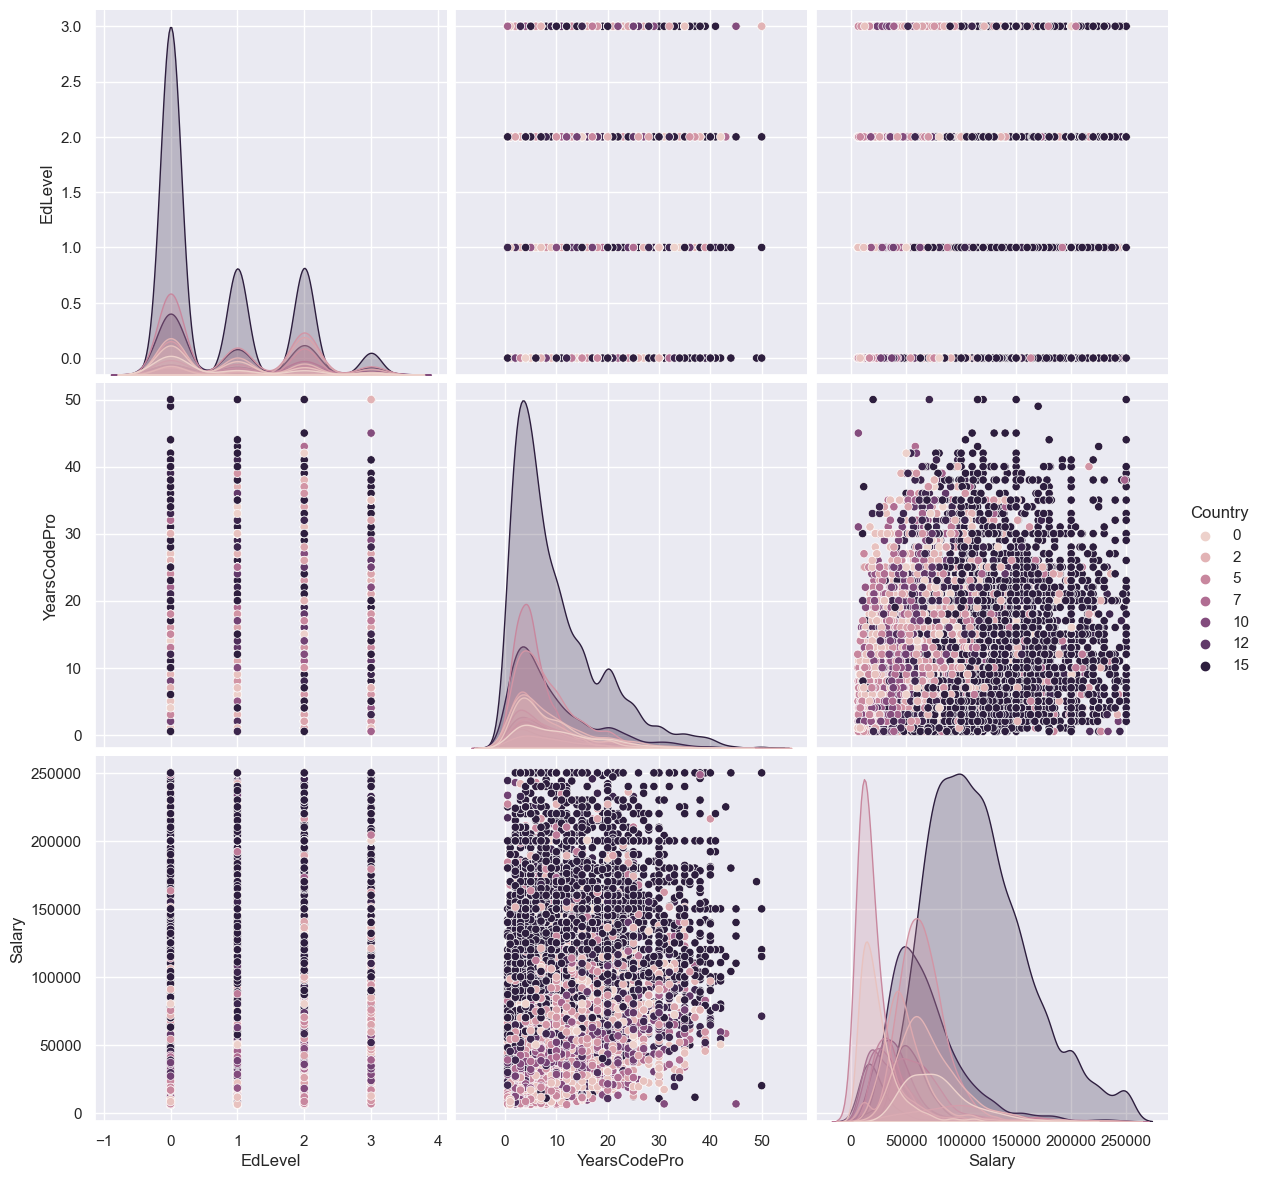

In [72]:
sns.pairplot(df, hue='Country', height=4);
